## Detect fake profiles in online social networks using Support Vector Machine

In [2]:
import sys
import csv
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import gender_guesser.detector as gender
from sklearn.preprocessing import Imputer
from sklearn import model_selection
from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import learning_curve, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
%matplotlib inline 

###### function for reading dataset from csv files

In [3]:
def read_datasets():
    """ Reads users profile from csv files """
    genuine_users = pd.read_csv("data/users.csv")
    fake_users = pd.read_csv("data/fusers.csv")
    # print genuine_users.columns
    # print genuine_users.describe()
    #print fake_users.describe()
    x=pd.concat([genuine_users,fake_users])   
    y=len(fake_users)*[0] + len(genuine_users)*[1]
    return x,y
    

###### function for predicting sex using name of person

In [4]:
def predict_sex(name):
    name=str(name)
    sex_predictor = gender.Detector( case_sensitive=False)
    first_name= name.split(' ')[0]
    sex= sex_predictor.get_gender(first_name)
    sex_dict={'female': -2, 'mostly_female': -1,'unknown':0,'mostly_male':1, 'male': 2}
    sex_code = sex_dict[sex]
    return sex_code

###### function for feature engineering

In [5]:
def extract_features(x):
    lang_list = list(enumerate(np.unique(x['lang'])))   
    lang_dict = { name : i for i, name in lang_list }             
    x.loc[:,'lang_code'] = x['lang'].map( lambda x: lang_dict[x]).astype(int)    
    x.loc[:,'sex_code']=predict_sex(x['name'])
    feature_columns_to_use = ['statuses_count','followers_count','friends_count','favourites_count','listed_count','sex_code','lang_code']
    x=x.loc[:,feature_columns_to_use]
    return x

###### function for ploting learning curve

In [6]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

###### function for plotting confusion matrix

In [7]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    target_names=['Fake','Genuine']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

###### function for plotting ROC curve

In [8]:
def plot_roc_curve(y_test, y_pred):
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    print ("False Positive rate: ",false_positive_rate)
    print ("True Positive rate: ",true_positive_rate)
    
    roc_auc = auc(false_positive_rate, true_positive_rate)

    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

###### Function for training data using Support Vector Machine

In [9]:
def train(X_train,y_train,X_test):
    # Scaling features
    X_train=preprocessing.scale(X_train)
    X_test=preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    cvk = StratifiedKFold(y_train,n_folds=5)
    classifier = SVC()
    clf = GridSearchCV(classifier,param_grid=param,cv=cvk)
    clf.fit(X_train,y_train)
    print("The best classifier is: ",clf.best_estimator_)
    clf.best_estimator_.fit(X_train,y_train)
    # Estimate score
    scores = cross_validation.cross_val_score(clf.best_estimator_, X_train,y_train, cv=5)
    print (scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' %clf.best_estimator_.gamma
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test,y_pred

In [10]:
def train_randomforest(X_train,y_train,X_test):
    # Scaling features
    X_train=preprocessing.scale(X_train)
    X_test=preprocessing.scale(X_test)

    Cs = 10.0 ** np.arange(-2,3,.5)
    gammas = 10.0 ** np.arange(-2,3,.5)
    param = [{'gamma': gammas, 'C': Cs}]
    cvk = StratifiedKFold(y_train,n_folds=5)
    classifier = SVC()
    clf = RandomForestClassifier()
    clf.fit(X_train,y_train)
    print("The best classifier is: ",clf.best_estimator_)
    clf.best_estimator_.fit(X_train,y_train)
    # Estimate score
    scores = cross_validation.cross_val_score(clf.best_estimator_, X_train,y_train, cv=5)
    print (scores)
    print('Estimated score: %0.5f (+/- %0.5f)' % (scores.mean(), scores.std() / 2))
    title = 'Learning Curves (SVM, rbf kernel, $\gamma=%.6f$)' %clf.best_estimator_.gamma
    plot_learning_curve(clf.best_estimator_, title, X_train, y_train, cv=5)
    plt.show()
    # Predict class
    y_pred = clf.best_estimator_.predict(X_test)
    return y_test,y_pred

In [11]:
print ("reading datasets.....\n")
x,y=read_datasets()

reading datasets.....



In [12]:
print ("extracting featues.....\n")
x=extract_features(x)
print (x.columns)
print (x.describe())

extracting featues.....

Index(['statuses_count', 'followers_count', 'friends_count',
       'favourites_count', 'listed_count', 'sex_code', 'lang_code'],
      dtype='object')
       statuses_count  followers_count  friends_count  favourites_count  \
count     2818.000000      2818.000000    2818.000000       2818.000000   
mean      1672.198368       371.105039     395.363023        234.541164   
std       4884.669157      8022.631339     465.694322       1445.847248   
min          0.000000         0.000000       0.000000          0.000000   
25%         35.000000        17.000000     168.000000          0.000000   
50%         77.000000        26.000000     306.000000          0.000000   
75%       1087.750000       111.000000     519.000000         37.000000   
max      79876.000000    408372.000000   12773.000000      44349.000000   

       listed_count  sex_code    lang_code  
count   2818.000000    2818.0  2818.000000  
mean       2.818666       0.0     2.851313  
std       23

In [13]:
print ("spliting datasets in train and test dataset...\n")
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size=0.20, random_state=44)

spliting datasets in train and test dataset...



# Random Forest

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
random_forest = RandomForestClassifier(n_estimators=100)

In [16]:
random_forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [17]:
y_pred = random_forest.predict(X_test)

In [18]:
random_forest.score(X_test,y_test)

0.9450354609929078

In [21]:
result_rf=random_forest.score(X_test,y_test)
import pickle
with open('rf.pkl','wb') as my_file_obj:
    pickle.dump(result_rf,my_file_obj)
print("File Stored Successfully")

File Stored Successfully


In [22]:
cnf_matrix = confusion_matrix(y_test,y_pred)

In [23]:
print(cnf_matrix)

[[267   1]
 [ 30 266]]


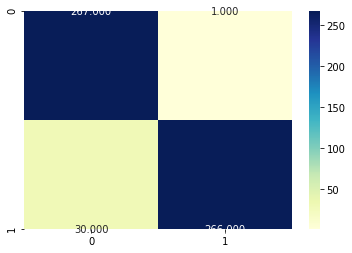

In [24]:
import seaborn as sns
labels = [0,1]
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)

# Deep Neural Network

In [27]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


In [28]:
model = Sequential([
    Dense(units=16, input_dim = 7,activation='relu'),
    Dense(units=24,activation='relu'),
    Dropout(0.5),
    Dense(20,activation='relu'),
    Dense(24,activation='relu'),
    Dense(1,activation='sigmoid'),
])

In [29]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                128       
_________________________________________________________________
dense_2 (Dense)              (None, 24)                408       
_________________________________________________________________
dropout_1 (Dropout)          (None, 24)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                500       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,565
Trainable params: 1,565
Non-trainable params: 0
____________________________________________________

In [30]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
model.fit(X_train,y_train,batch_size=7,epochs=5)

Epoch 1/5
2254/2254 [==============================] - 2s 703us/step - loss: 10.1859 - accuracy: 0.7928
Epoch 2/5
2254/2254 [==============================] - 2s 722us/step - loss: 9.0801 - accuracy: 0.8749
Epoch 3/5
2254/2254 [==============================] - 2s 709us/step - loss: 4.6736 - accuracy: 0.8425
Epoch 4/5
2254/2254 [==============================] - 2s 772us/step - loss: 1.3266 - accuracy: 0.8629
Epoch 5/5
2254/2254 [==============================] - 2s 769us/step - loss: 1.0617 - accuracy: 0.8807


In [31]:
score = model.evaluate(X_test, y_test)

564/564 [==============================] - 0s 143us/step


In [32]:
print(score)

result_dnn=score[1]
print(result_dnn)

[4.149176748931831, 0.9078013896942139]
0.9078013896942139


In [33]:
import pickle

with open('dnn.pkl','wb') as my_file_obj:
    pickle.dump(result_dnn,my_file_obj)
print("File Stored Successfully")

File Stored Successfully


In [34]:
y_pred = model.predict(X_test)
y_test = pd.DataFrame(y_test)

In [35]:
cnf_matrix = confusion_matrix(y_test, y_pred.round())

In [36]:
print(cnf_matrix)

[[242  26]
 [ 26 270]]


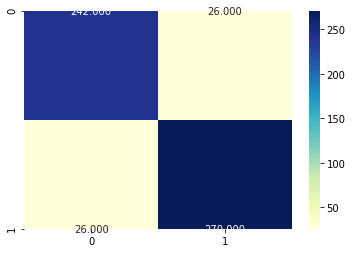

In [37]:
import seaborn as sns
labels = [0,1]
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)